In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import os
from matplotlib import pyplot
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
%matplotlib inline
%config InlineBackend.figure_format='retina'
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
#import all essential libraries
import sys
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph
import seaborn as sns # used for plot interactive graph.
from sklearn.metrics import mean_squared_error,r2_score
## Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error
import pandas as pd
print(f'pandas version: {pd.__version__}')

pandas version: 1.1.5


# **ทดลองสร้าง LSTM Model**

# เรียกดูข้อมูลหลัง Clean Data

In [ ]:
#dataset ผ่านการ Clean แล้ว
PM_w = pd.read_csv('https://raw.githubusercontent.com/Bewsure/DataLSTM/main/newPM_Clean.csv')
PM_w.set_index('date', inplace=True)
PM_w.head()

,pressure,wind_speed,humidity,temperature,PM10,PM2.5
date,,,,,,
2017-11-01,101013.3203,2.700052,67.445312,27.344531,57.0,43.0
2017-11-02,100784.9225,2.324088,63.472868,28.941860,55.0,43.0
2017-11-03,100780.4428,2.484124,57.516605,29.244280,65.0,40.0
2017-11-04,100807.7431,2.696210,50.972222,28.576736,54.0,51.0
2017-11-05,100865.8363,4.023996,60.676157,25.747331,64.0,33.0


In [ ]:
PM_w.shape

(1157, 6)

# ใส่ฟังก์ชันสำหรับประมวลผลข้อมูล Time series หลายตัวแปร + ทำ min max scaling

In [ ]:
# function สำหรับ preprocess ข้อมูล time series หลายตัวแปร
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg



dataset = PM_w
values = dataset.values
values = values.astype('float32')

# ทำ scaling ข้อมูลด้วยวิธี min max scaling เปลี่ยน scale ข้อมูลแต่ละ column ให้อยู่ระหว่าง [0,1] และเก็บค่า min max แต่ละ column ไว้สำหรับทำ rescale ข้อมูลภายหลัง
min_dict = dict()
max_dict = dict()
for col in dataset.columns:
  min_dict[col] = dataset[col].min()
  max_dict[col] = dataset[col].max()
  dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())

# ใช้ function สำหรับ preprocess ข้อมูลที่เขียนไว้ และ drop column ที่ไม่ได้ใช้
reframed = series_to_supervised(dataset.values, 30, 7,feat_name=PM_w.columns)

In [ ]:
reframed.head()

,pressure(t-30),wind_speed(t-30),humidity(t-30),temperature(t-30),PM10(t-30),PM2.5(t-30),pressure(t-29),wind_speed(t-29),humidity(t-29),temperature(t-29),PM10(t-29),PM2.5(t-29),pressure(t-28),wind_speed(t-28),humidity(t-28),temperature(t-28),PM10(t-28),PM2.5(t-28),pressure(t-27),wind_speed(t-27),humidity(t-27),temperature(t-27),PM10(t-27),PM2.5(t-27),pressure(t-26),wind_speed(t-26),humidity(t-26),temperature(t-26),PM10(t-26),PM2.5(t-26),pressure(t-25),wind_speed(t-25),humidity(t-25),temperature(t-25),PM10(t-25),PM2.5(t-25),pressure(t-24),wind_speed(t-24),humidity(t-24),temperature(t-24),PM10(t-24),PM2.5(t-24),pressure(t-23),wind_speed(t-23),humidity(t-23),temperature(t-23),PM10(t-23),PM2.5(t-23),pressure(t-22),wind_speed(t-22),humidity(t-22),temperature(t-22),PM10(t-22),PM2.5(t-22),pressure(t-21),wind_speed(t-21),humidity(t-21),temperature(t-21),PM10(t-21),PM2.5(t-21),pressure(t-20),wind_speed(t-20),humidity(t-20),temperature(t-20),PM10(t-20),PM2.5(t-20),pressure(t-19),wind_speed(t-19),humidity(t-19),temperature(t-19),PM10(t-19),PM2.5(t-19),pressure(t-18),wind_speed(t-18),humidity(t-18),temperature(t-18),PM10(t-18),PM2.5(t-18),pressure(t-17),wind_speed(t-17),humidity(t-17),temperature(t-17),PM10(t-17),PM2.5(t-17),pressure(t-16),wind_speed(t-16),humidity(t-16),temperature(t-16),PM10(t-16),PM2.5(t-16),pressure(t-15),wind_speed(t-15),humidity(t-15),temperature(t-15),PM10(t-15),PM2.5(t-15),pressure(t-14),wind_speed(t-14),humidity(t-14),temperature(t-14),PM10(t-14),PM2.5(t-14),pressure(t-13),wind_speed(t-13),humidity(t-13),temperature(t-13),PM10(t-13),PM2.5(t-13),pressure(t-12),wind_speed(t-12),humidity(t-12),temperature(t-12),PM10(t-12),PM2.5(t-12),pressure(t-11),wind_speed(t-11),humidity(t-11),temperature(t-11),PM10(t-11),PM2.5(t-11),pressure(t-10),wind_speed(t-10),humidity(t-10),temperature(t-10),PM10(t-10),PM2.5(t-10),pressure(t-9),wind_speed(t-9),humidity(t-9),temperature(t-9),PM10(t-9),PM2.5(t-9),pressure(t-8),wind_speed(t-8),humidity(t-8),temperature(t-8),PM10(t-8),PM2.5(t-8),pressure(t-7),wind_speed(t-7),humidity(t-7),temperature(t-7),PM10(t-7),PM2.5(t-7),pressure(t-6),wind_speed(t-6),humidity(t-6),temperature(t-6),PM10(t-6),PM2.5(t-6),pressure(t-5),wind_speed(t-5),humidity(t-5),temperature(t-5),PM10(t-5),PM2.5(t-5),pressure(t-4),wind_speed(t-4),humidity(t-4),temperature(t-4),PM10(t-4),PM2.5(t-4),pressure(t-3),wind_speed(t-3),humidity(t-3),temperature(t-3),PM10(t-3),PM2.5(t-3),pressure(t-2),wind_speed(t-2),humidity(t-2),temperature(t-2),PM10(t-2),PM2.5(t-2),pressure(t-1),wind_speed(t-1),humidity(t-1),temperature(t-1),PM10(t-1),PM2.5(t-1),pressure(t),wind_speed(t),humidity(t),temperature(t),PM10(t),PM2.5(t),pressure(t+1),wind_speed(t+1),humidity(t+1),temperature(t+1),PM10(t+1),PM2.5(t+1),pressure(t+2),wind_speed(t+2),humidity(t+2),temperature(t+2),PM10(t+2),PM2.5(t+2),pressure(t+3),wind_speed(t+3),humidity(t+3),temperature(t+3),PM10(t+3),PM2.5(t+3),pressure(t+4),wind_speed(t+4),humidity(t+4),temperature(t+4),PM10(t+4),PM2.5(t+4),pressure(t+5),wind_speed(t+5),humidity(t+5),temperature(t+5),PM10(t+5),PM2.5(t+5),pressure(t+6),wind_speed(t+6),humidity(t+6),temperature(t+6),PM10(t+6),PM2.5(t+6)
30,0.767782,0.219516,0.454343,0.535788,0.5375,0.416667,0.705332,0.188950,0.375677,0.651000,0.5125,0.416667,0.704107,0.201961,0.257727,0.672813,0.6375,0.380952,0.711572,0.219204,0.128131,0.624664,0.5000,0.511905,0.727456,0.327154,0.320295,0.420585,0.6250,0.297619,0.729517,0.188413,0.528324,0.387238,0.5000,0.476190,0.715748,0.187702,0.516270,0.545075,0.4625,0.357143,0.732285,0.096816,0.526184,0.554185,0.4125,0.333333,0.707573,0.134696,0.506616,0.641702,0.4125,0.250000,0.702658,0.144328,0.547321,0.697341,0.2875,0.238095,0.718358,0.137528,0.720623,0.537250,0.3375,0.154762,0.680581,0.132048,0.603391,0.640624,0.4625,0.214286,0.669771,0.130208,0.738763,0.594819,0.5250,0.297619,0.682494,0.097674,0.685736,0.654657,0.5875,0.369048,0.711148,0.118190,0.598919,0.688539,0.3625,0.357143,0.724038,0.137686,0.744050,0.613990,0.5750,0.190476,0.703235,0.07858

In [ ]:
reframed.drop(['pressure(t)','wind_speed(t)','humidity(t)','temperature(t)','PM10(t)','pressure(t+1)','wind_speed(t+1)','humidity(t+1)','temperature(t+1)','PM10(t+1)','pressure(t+2)','wind_speed(t+2)','humidity(t+2)','temperature(t+2)','PM10(t+2)','pressure(t+3)','wind_speed(t+3)','humidity(t+3)','temperature(t+3)','PM10(t+3)','pressure(t+4)','wind_speed(t+4)','humidity(t+4)','temperature(t+4)','PM10(t+4)','pressure(t+5)','wind_speed(t+5)','humidity(t+5)','temperature(t+5)','PM10(t+5)','pressure(t+6)','wind_speed(t+6)','humidity(t+6)','temperature(t+6)','PM10(t+6)'],axis=1,inplace=True)

# แบ่งข้อมูล Train,Test (train ใช้สำหรับให้โมเดลเข้าใจทิศทางการทำงานของข้อมูลโดยศึกษาจาก Input+Output หลังจากนั้นทดสอบโมเดลโดยการ Test โดยให้โมเดลวิเคราะห์ Input และลอง Forcast Output)

In [ ]:
# split into train and test sets
values = reframed.values
n_train_percent = 0.9
split = int(values.shape[0]*0.9)
train = values[:split, :]
test = values[split:, :]
date_reframed = dataset.index[reframed.index]
date_train = date_reframed[:split]
date_test = date_reframed[split:]

# แบ่ง Input,Output (Output = PM2.5(t)ที่เหลือเป็น Input)

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :-7], train[:, -7:]
test_X, test_y = test[:, :-7], test[:, -7:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [ ]:
train_X.shape

(1008, 1, 180)

In [ ]:
train_y.shape

(1008, 7)

# สร้างโมเดล กำหนด Optimizer+จูนพารามิเตอร์

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(7))
model.compile(loss='mae', optimizer='Adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/100
202/202 - 3s - loss: 0.1206 - val_loss: 0.1491
Epoch 2/100
202/202 - 0s - loss: 0.1254 - val_loss: 0.1222
Epoch 3/100
202/202 - 0s - loss: 0.1145 - val_loss: 0.1040
Epoch 4/100
202/202 - 0s - loss: 0.1031 - val_loss: 0.0948
Epoch 5/100
202/202 - 0s - loss: 0.0959 - val_loss: 0.0917
Epoch 6/100
202/202 - 0s - loss: 0.0922 - val_loss: 0.0901
Epoch 7/100
202/202 - 0s - loss: 0.0900 - val_loss: 0.0881
Epoch 8/100
202/202 - 0s - loss: 0.0884 - val_loss: 0.0878
Epoch 9/100
202/202 - 0s - loss: 0.0873 - val_loss: 0.0880
Epoch 10/100
202/202 - 0s - loss: 0.0867 - val_loss: 0.0881
Epoch 11/100
202/202 - 0s - loss: 0.0855 - val_loss: 0.0878
Epoch 12/100
202/202 - 0s - loss: 0.0845 - val_loss: 0.0855
Epoch 13/100
202/202 - 0s - loss: 0.0831 - val_loss: 0.0849
Epoch 14/100
202/202 - 0s - loss: 0.0825 - val_loss: 0.0836
Epoch 15/100
202/202 - 0s - loss: 0.0816 - val_loss: 0.0841
Epoch 16/100
202/202 - 0s - loss: 0.0810 - val_loss: 0.0838
Epoch 17/100
202/202 - 0s - loss: 0.0803 - val_lo

# ดูค่า Loss function เปรียบเทียบ Train,Test

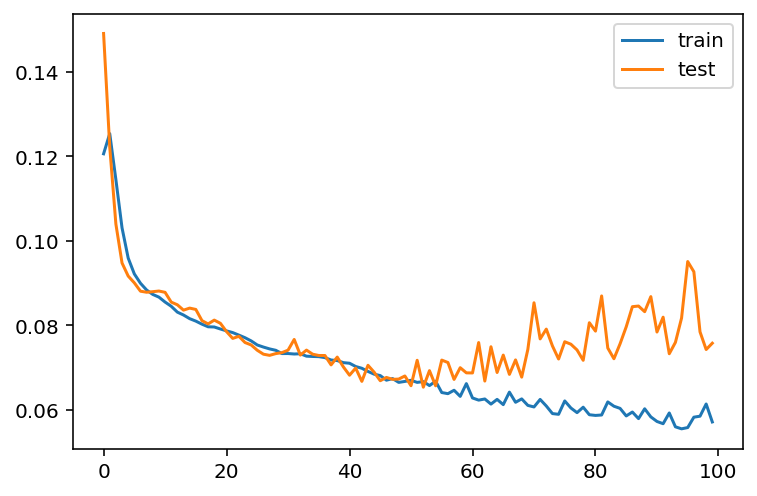

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# เริ่ม Forecast PM2.5 จาก Test Data

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

เปลี่ยนค่า Forcast กลับเป็นหน่วยเดิม เนื่องจากค่า Forcast เป็นค่าที่ทำ Scalling

In [ ]:
inv_yhat = yhat*(max_dict['PM2.5']-min_dict['PM2.5'])+min_dict['PM2.5']
inv_y = test_y*(max_dict['PM2.5']-min_dict['PM2.5'])+min_dict['PM2.5']

In [ ]:
inv_yhat.shape

(113, 7)

# ประเมินประสิทธิภาพโมเดลด้วย RMSE,MAE,MAEP

In [ ]:
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.2f' % rmse)

Test RMSE: 8.47


In [ ]:
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.2f' %mae )

Test MAE: 6.37


In [ ]:
mape = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print('Test MAPE: %.2f' %mape)

Test MAPE: 25.19


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                46200     
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 357       
Total params: 46,557
Trainable params: 46,557
Non-trainable params: 0
_________________________________________________________________


# เปรียบเทียบค่า Forcast ,Actual

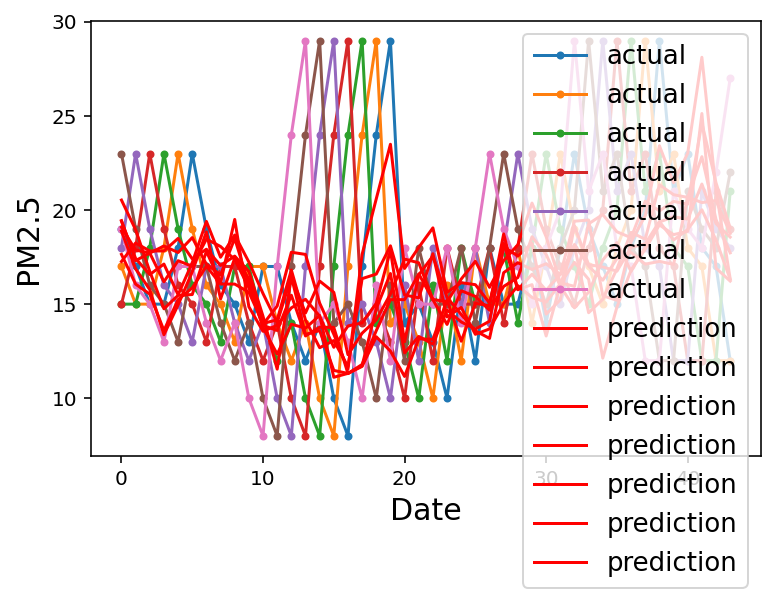

In [ ]:
aa=[x for x in range(44)]
plt.plot(aa, inv_y[:44], marker='.', label="actual")
plt.plot(aa, inv_yhat[:44], 'r', label="prediction")
plt.ylabel('PM2.5', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

# Output ที่ได้ (inv_yhat) และ ค่าที่เก็บข้อมูลจริงๆจากสถานี (inv_y)

In [ ]:
inv_yhat

array([[18.878235 , 17.643639 , 20.527164 , 19.084488 , 19.404976 ,
        19.435942 , 17.26246  ],
       [16.873924 , 16.062927 , 18.951477 , 17.873325 , 17.426094 ,
        17.312706 , 18.248531 ],
       [15.774506 , 15.531502 , 16.735338 , 17.71048  , 16.572704 ,
        17.711163 , 17.82189  ],
       [13.3751545, 13.594642 , 14.753473 , 16.187368 , 17.127552 ,
        18.087898 , 17.825241 ],
       [14.956092 , 15.23927  , 15.466518 , 17.306797 , 15.495396 ,
        17.74289  , 18.48991  ],
       [16.716982 , 15.863309 , 15.509253 , 17.006144 , 17.199295 ,
        18.534134 , 17.405926 ],
       [18.84117  , 17.015135 , 17.80846  , 18.453436 , 19.392876 ,
        17.120766 , 17.917526 ],
       [15.272431 , 16.067282 , 16.128916 , 18.061096 , 17.490406 ,
        16.554249 , 17.055176 ],
       [17.437843 , 16.065786 , 19.499435 , 17.371166 , 18.67189  ,
        18.491814 , 17.551739 ],
       [16.348553 , 15.632725 , 14.860878 , 15.872648 , 17.235912 ,
        16.048359 , 16.

In [ ]:
inv_y

array([[19., 17., 15., 15., 18., 23., 19.],
       [17., 15., 15., 18., 23., 19., 16.],
       [15., 15., 18., 23., 19., 16., 15.],
       [15., 18., 23., 19., 16., 15., 13.],
       [18., 23., 19., 16., 15., 13., 17.],
       [23., 19., 16., 15., 13., 17., 17.],
       [19., 16., 15., 13., 17., 17., 14.],
       [16., 15., 13., 17., 17., 14., 12.],
       [15., 13., 17., 17., 14., 12., 14.],
       [13., 17., 17., 14., 12., 14., 10.],
       [17., 17., 14., 12., 14., 10.,  8.],
       [17., 14., 12., 14., 10.,  8., 17.],
       [14., 12., 14., 10.,  8., 17., 24.],
       [12., 14., 10.,  8., 17., 24., 29.],
       [14., 10.,  8., 17., 24., 29., 14.],
       [10.,  8., 17., 24., 29., 14., 15.],
       [ 8., 17., 24., 29., 14., 15., 13.],
       [17., 24., 29., 14., 15., 13., 10.],
       [24., 29., 14., 15., 13., 10., 16.],
       [29., 14., 15., 13., 10., 16., 12.],
       [14., 15., 13., 10., 16., 12., 18.],
       [15., 13., 10., 16., 12., 18., 15.],
       [13., 10., 16., 12., 18.,

# **นำโมเดลมาใช้งานกับข้อมูล Real-time**

In [ ]:
from datetime import datetime
str(datetime.now())

'2021-07-05 09:33:26.314194'

เรียกดูข้อมูลจาก Google Sheet ที่เก็บข้อมูล Realtime

In [ ]:
url='https://docs.google.com/spreadsheets/d/17pyqTFA6PoQzFd6Hmob9sPP9FoaZ8NAJTYoFFktNX-w/export?gid=0&format=csv'
df_r= pd.read_csv(url)
df_r

,date,PM2.5,PM10,temperature,humidity,pressure,wind_speed
0,6/6/2021 8:54:14,16,30,33.000,48.00,100575.78,12.50
1,6/7/2021 8:54:14,22,35,32.000,53.00,100575.78,12.40
2,6/8/2021 8:54:14,15,33,32.000,48.00,100575.78,10.30
3,6/9/2021 8:54:14,15,46,30.000,62.00,100575.78,7.10
4,6/10/2021 16:08:44,21,47,29.040,63.06,100557.25,6.07
5,6/11/2021 8:54:15,15,30,31.080,64.69,100468.24,6.37
6,6/12/2021 8:54:14,14,29,32.560,58.96,100466.14,6.20
7,6/13/2021 8:54:15,19,42,32.630,54.31,100547.28,5.74
8,6/14/2021 8:54:18,18,39,30.070,66.02,100638.20,6.28
9,6/15/2021 8:54:14,14,32,29.985,69.54,100630.73,5.25


แปลง date จาก Object --> date + เซต Column date เป็น Index

In [ ]:
df_r['date'] = pd.to_datetime(df_r['date']).dt.date

In [ ]:
df_r.set_index('date', inplace=True)

## แสดงข้อมูล 30 วันล่าสุด

In [ ]:
df_r = df_r.tail(30)
df_r

,PM2.5,PM10,temperature,humidity,pressure,wind_speed
date,,,,,,
2021-06-06,16,30,33.000,48.00,100575.78,12.50
2021-06-07,22,35,32.000,53.00,100575.78,12.40
2021-06-08,15,33,32.000,48.00,100575.78,10.30
2021-06-09,15,46,30.000,62.00,100575.78,7.10
2021-06-10,21,47,29.040,63.06,100557.25,6.07
2021-06-11,15,30,31.080,64.69,100468.24,6.37
2021-06-12,14,29,32.560,58.96,100466.14,6.20
2021-06-13,19,42,32.630,54.31,100547.28,5.74
2021-06-14,18,39,30.070,66.02,100638.20,6.28


In [ ]:
real_data = df_r.copy()

In [ ]:
real_data

,PM2.5,PM10,temperature,humidity,pressure,wind_speed
date,,,,,,
2021-06-06,16,30,33.000,48.00,100575.78,12.50
2021-06-07,22,35,32.000,53.00,100575.78,12.40
2021-06-08,15,33,32.000,48.00,100575.78,10.30
2021-06-09,15,46,30.000,62.00,100575.78,7.10
2021-06-10,21,47,29.040,63.06,100557.25,6.07
2021-06-11,15,30,31.080,64.69,100468.24,6.37
2021-06-12,14,29,32.560,58.96,100466.14,6.20
2021-06-13,19,42,32.630,54.31,100547.28,5.74
2021-06-14,18,39,30.070,66.02,100638.20,6.28


# ใส่ฟังก์ชันสำหรับประมวลผลข้อมูล Time series หลายตัวแปร + ทำ min max scaling

In [ ]:
# function สำหรับ preprocess ข้อมูล time series หลายตัวแปร
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# เลือกข้อมูลจาก list ของ DataFrame และ drop column 'Close' เนื่องจากเราจะใช้ column 'Adj. Close' เท่านั้น

dataset = df_r
values = dataset.values
values = values.astype('float32')

# ทำ scaling ข้อมูลด้วยวิธี min max scaling เปลี่ยน scale ข้อมูลแต่ละ column ให้อยู่ระหว่าง [0,1] และเก็บค่า min max แต่ละ column ไว้สำหรับทำ rescale ข้อมูลภายหลัง
min_dict = dict()
max_dict = dict()
for col in dataset.columns:
  min_dict[col] = dataset[col].min()
  max_dict[col] = dataset[col].max()
  dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())

# ใช้ function สำหรับ preprocess ข้อมูลที่เขียนไว้ และ drop column ที่ไม่ได้ใช้
reframed = series_to_supervised(dataset.values, 29, 1,feat_name=df_r.columns)


In [ ]:
reframed

,PM2.5(t-29),PM10(t-29),temperature(t-29),humidity(t-29),pressure(t-29),wind_speed(t-29),PM2.5(t-28),PM10(t-28),temperature(t-28),humidity(t-28),pressure(t-28),wind_speed(t-28),PM2.5(t-27),PM10(t-27),temperature(t-27),humidity(t-27),pressure(t-27),wind_speed(t-27),PM2.5(t-26),PM10(t-26),temperature(t-26),humidity(t-26),pressure(t-26),wind_speed(t-26),PM2.5(t-25),PM10(t-25),temperature(t-25),humidity(t-25),pressure(t-25),wind_speed(t-25),PM2.5(t-24),PM10(t-24),temperature(t-24),humidity(t-24),pressure(t-24),wind_speed(t-24),PM2.5(t-23),PM10(t-23),temperature(t-23),humidity(t-23),pressure(t-23),wind_speed(t-23),PM2.5(t-22),PM10(t-22),temperature(t-22),humidity(t-22),pressure(t-22),wind_speed(t-22),PM2.5(t-21),PM10(t-21),temperature(t-21),humidity(t-21),pressure(t-21),wind_speed(t-21),PM2.5(t-20),PM10(t-20),temperature(t-20),humidity(t-20),pressure(t-20),wind_speed(t-20),PM2.5(t-19),PM10(t-19),temperature(t-19),humidity(t-19),pressure(t-19),wind_speed(t-19),PM2.5(t-18),PM10(t-18),temperature(t-18),humidity(t-18),pressure(t-18),wind_speed(t-18),PM2.5(t-17),PM10(t-17),temperature(t-17),humidity(t-17),pressure(t-17),wind_speed(t-17),PM2.5(t-16),PM10(t-16),temperature(t-16),humidity(t-16),pressure(t-16),wind_speed(t-16),PM2.5(t-15),PM10(t-15),temperature(t-15),humidity(t-15),pressure(t-15),wind_speed(t-15),PM2.5(t-14),PM10(t-14),temperature(t-14),humidity(t-14),pressure(t-14),wind_speed(t-14),PM2.5(t-13),PM10(t-13),temperature(t-13),humidity(t-13),pressure(t-13),wind_speed(t-13),PM2.5(t-12),PM10(t-12),temperature(t-12),humidity(t-12),pressure(t-12),wind_speed(t-12),PM2.5(t-11),PM10(t-11),temperature(t-11),humidity(t-11),pressure(t-11),wind_speed(t-11),PM2.5(t-10),PM10(t-10),temperature(t-10),humidity(t-10),pressure(t-10),wind_speed(t-10),PM2.5(t-9),PM10(t-9),temperature(t-9),humidity(t-9),pressure(t-9),wind_speed(t-9),PM2.5(t-8),PM10(t-8),temperature(t-8),humidity(t-8),pressure(t-8),wind_speed(t-8),PM2.5(t-7),PM10(t-7),temperature(t-7),humidity(t-7),pressure(t-7),wind_speed(t-7),PM2.5(t-6),PM10(t-6),temperature(t-6),humidity(t-6),pressure(t-6),wind_speed(t-6),PM2.5(t-5),PM10(t-5),temperature(t-5),humidity(t-5),pressure(t-5),wind_speed(t-5),PM2.5(t-4),PM10(t-4),temperature(t-4),humidity(t-4),pressure(t-4),wind_speed(t-4),PM2.5(t-3),PM10(t-3),temperature(t-3),humidity(t-3),pressure(t-3),wind_speed(t-3),PM2.5(t-2),PM10(t-2),temperature(t-2),humidity(t-2),pressure(t-2),wind_speed(t-2),PM2.5(t-1),PM10(t-1),temperature(t-1),humidity(t-1),pressure(t-1),wind_speed(t-1),PM2.5(t),PM10(t),temperature(t),humidity(t),pressure(t),wind_speed(t)
29,0.333333,0.184211,1.0,0.0,0.368004,1.0,0.733333,0.315789,0.747475,0.204415,0.368004,0.987212,0.266667,0.263158,0.747475,0.0,0.368004,0.71867,0.266667,0.605263,0.242424,0.572363,0.368004,0.309463,0.666667,0.631579,0.0,0.615699,0.328436,0.177749,0.266667,0.184211,0.515152,0.682339,0.13837,0.216113,0.2,0.157895,0.888889,0.448078,0.133886,0.194373,0.533333,0.5,0.906566,0.257972,0.307147,0.13555,0.466667,0.421053,0.260101,0.736713,0.501292,0.204604,0.2,0.236842,0.238636,0.880621,0.485341,0.07289,0.133333,0.131579,0.049242,1.0,0.786893,0.12532,0.066667,0.078947,0.368687,0.70646,0.936858,0.102302,0.4,0.315789,0.414141,0.59076,1.0,0.040921,0.2,0.210526,0.497475,0.496729,0.902372,0.070332,0.2,0.184211,0.537879,0.502044,0.655463,0.069054,0.4,0.342105,0.477273,0.619787,0.497235,0.065217,1.0,0.921053,0.458333,0.543336,0.67861,0.106138,1.0,1.0,0.465909,0.376942,0.856527,0.084399,0.4,0.368421,0.412879,0.448487,0.596186,0.069054,0.4,0.394737,0.424242,0.556419,0.363349,0.095908,0.533333,0.421053,0.396465,0.631235,0.559523,0.065217,0.333333,0.263158,0.473485,0.613246,0.86479,0.152174,0.066667,0.052632,0.679293,0.561325,0.743247,0.439898,0.6,0.368421,0.587121,0.52085,0.566099,0.158568,0.333333,0.263158,0.627525,0.61202,0.497149,0.723785,0.266667,0.210526,0.429293,0.453393,0.528923,0.0,0.2,0.105263,0.516414,0.676206,0.677906,0.180307,0.4,0.236842,0.79798,0.454211,0.390382,0.028133,0.066667,0.052632,0.77904,0.369174,0.223207

In [ ]:
reframed.shape

(1, 180)

# กำหนด Input ให้เป็นคุณภาพอากาศ+PM2.5+PM10 ของ 30 วันก่อนหน้า เพื่อทำนาย 7 วันถัดไป

In [ ]:
test_X = reframed.to_numpy()

In [ ]:
test_X

array([[0.33333333, 0.18421053, 1.        , 0.        , 0.3680041 ,
        1.        , 0.73333333, 0.31578947, 0.74747475, 0.20441537,
        0.3680041 , 0.98721228, 0.26666667, 0.26315789, 0.74747475,
        0.        , 0.3680041 , 0.71867008, 0.26666667, 0.60526316,
        0.24242424, 0.57236304, 0.3680041 , 0.30946292, 0.66666667,
        0.63157895, 0.        , 0.6156991 , 0.32843629, 0.17774936,
        0.26666667, 0.18421053, 0.51515152, 0.68233851, 0.13836988,
        0.21611253, 0.2       , 0.15789474, 0.88888889, 0.4480785 ,
        0.13388567, 0.1943734 , 0.53333333, 0.5       , 0.90656566,
        0.2579722 , 0.30714698, 0.13554987, 0.46666667, 0.42105263,
        0.26010101, 0.736713  , 0.50129188, 0.20460358, 0.2       ,
        0.23684211, 0.23863636, 0.88062142, 0.48534091, 0.07289003,
        0.13333333, 0.13157895, 0.04924242, 1.        , 0.7868933 ,
        0.12531969, 0.06666667, 0.07894737, 0.36868687, 0.70645953,
        0.93685806, 0.10230179, 0.4       , 0.31

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
test_X

array([[[0.33333333, 0.18421053, 1.        , 0.        , 0.3680041 ,
         1.        , 0.73333333, 0.31578947, 0.74747475, 0.20441537,
         0.3680041 , 0.98721228, 0.26666667, 0.26315789, 0.74747475,
         0.        , 0.3680041 , 0.71867008, 0.26666667, 0.60526316,
         0.24242424, 0.57236304, 0.3680041 , 0.30946292, 0.66666667,
         0.63157895, 0.        , 0.6156991 , 0.32843629, 0.17774936,
         0.26666667, 0.18421053, 0.51515152, 0.68233851, 0.13836988,
         0.21611253, 0.2       , 0.15789474, 0.88888889, 0.4480785 ,
         0.13388567, 0.1943734 , 0.53333333, 0.5       , 0.90656566,
         0.2579722 , 0.30714698, 0.13554987, 0.46666667, 0.42105263,
         0.26010101, 0.736713  , 0.50129188, 0.20460358, 0.2       ,
         0.23684211, 0.23863636, 0.88062142, 0.48534091, 0.07289003,
         0.13333333, 0.13157895, 0.04924242, 1.        , 0.7868933 ,
         0.12531969, 0.06666667, 0.07894737, 0.36868687, 0.70645953,
         0.93685806, 0.10230179, 0

# ใส่ค่า Input ใน Model

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [ ]:
yhat

array([[-0.03200712,  0.00568609,  0.12257573,  0.16446175,  0.21246843,
         0.1855166 ,  0.3463853 ]], dtype=float32)

In [ ]:
inv_yhat = yhat*(max_dict['PM2.5']-min_dict['PM2.5'])+min_dict['PM2.5']

# แสดงค่า Forcast (ไมโครกรัมต่อลูกบาศก์เมตร หรือ µg./m.)

In [ ]:
inv_yhat

array([[10.519894, 11.085291, 12.838636, 13.466927, 14.187027, 13.782749,
        16.19578 ]], dtype=float32)

In [ ]:
re_sh = inv_yhat

In [ ]:
re_sh

array([[10.519894, 11.085291, 12.838636, 13.466927, 14.187027, 13.782749,
        16.19578 ]], dtype=float32)

In [ ]:
re_sh = re_sh.reshape(7,1)

# นำข้อมูลที่ Forcast มาแสดงเป็น Dataframe

In [ ]:
import datetime
import pandas as pd
import numpy as np

todays_date = datetime.datetime.now().date()
date = pd.date_range(todays_date+datetime.timedelta(1), periods=7,freq='D')

columns = ['PM25']

In [ ]:
df_ = pd.DataFrame(index=date, columns=columns)
df_ = df_.fillna(0) # with 0s rather than NaNs

In [ ]:
df_

,PM25
2021-07-06,0
2021-07-07,0
2021-07-08,0
2021-07-09,0
2021-07-10,0
2021-07-11,0
2021-07-12,0


In [ ]:
df_ = pd.DataFrame(re_sh, index= date, columns=columns)
df_

,PM25
2021-07-06,10.519894
2021-07-07,11.085291
2021-07-08,12.838636
2021-07-09,13.466927
2021-07-10,14.187027
2021-07-11,13.782749
2021-07-12,16.195780


In [ ]:
df_.reset_index(level=0, inplace=True)

In [ ]:
df_ =df_.rename(columns = {'index':'date'})


In [ ]:
#อ่านข้อมูลจาก sheet แสดงใน colab และอัพเดทข้อมูลใน sheet จาก colab
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
#ชีทที่ใช้เก็บข้อมูล
data = 'https://docs.google.com/spreadsheets/d/1Vm5h05JdHpl76-aDFf9RDXYKs1KoW-NVa-am26b6GHE/edit?usp=sharing'
#ตั้งค่าชีท
wb = gc.open_by_url(data)
sheet = wb.worksheet('Sheet1')
data = sheet.get_all_values()
print(data) #อ่านข้อมูลในชีท

[['date', 'PM25'], ['2021-07-06 0:00:00', '10.14430523'], ['2021-07-07 0:00:00', '10.1775198'], ['2021-07-08 0:00:00', '11.11591434'], ['2021-07-09 0:00:00', '11.16963387'], ['2021-07-10 0:00:00', '12.97088337'], ['2021-07-11 0:00:00', '12.32719803'], ['2021-07-12 0:00:00', '12.92806244']]


In [ ]:
#แปลงข้อมูลหน้าชีทที่ต้องการ เป็น Dataframe โดย gspread_dataframe#
from gspread_dataframe import get_as_dataframe, set_with_dataframe
#ตัวแปร sheet คือตัวแปรเดียวกับ โค้ดข้างบน โดยดึงข้อมูลหน้าชีทนั้นๆออกมาแปลงเป็น Dataframe เพื่อเอาไปทำงานต่อ#
#df_ = get_as_dataframe(sheet)
#เปลี่ยนแปลงข้อมูล Dataframe เสร็จแล้วต้องการบันทึก Dataframe ลง Google Sheet#
set_with_dataframe(wb.worksheet('Sheet1'), df_)